# Sprint 2
## CIS 512 Final project
### Benjamin Kanouse

#### Import packages, setup constance,  and import data data.

In [1]:
import pandas as pd 
import numpy as np
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import cpi
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 100
alt.renderers.enable('notebook')

train_data = DataFrame(pd.read_csv('train.csv'))
test_data = DataFrame(pd.read_csv('test.csv'))

/anaconda3/lib/python3.7/site-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


## Sprint 1 code to clean the dataset

In [2]:
percentage_null = np.sum(test_data.isnull()) / len(test_data.index) > 0.7
bad_columns = list(percentage_null.index[percentage_null])

train_data.drop(bad_columns,axis=1,inplace=True)
test_data.drop(bad_columns,axis=1,inplace=True)

train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean(), inplace = True)
train_data['MasVnrType'].fillna('None', inplace = True)
train_data['MasVnrArea'].fillna(0.0, inplace = True)
train_data['BsmtQual'].fillna('NA', inplace = True)
train_data['BsmtCond'].fillna('NA', inplace = True)
train_data['BsmtExposure'].fillna('NA', inplace = True)
train_data['BsmtFinType1'].fillna('NA', inplace = True)
train_data['BsmtFinType2'].fillna('NA', inplace = True)
train_data['Electrical'].fillna(train_data['Electrical'].dropna().value_counts().idxmax(), inplace = True)
train_data['FireplaceQu'].fillna('NA', inplace = True)
train_data['GarageType'].fillna('NA', inplace = True)
train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace = True)
train_data['GarageFinish'].fillna('NA', inplace = True)
train_data['GarageQual'].fillna('NA', inplace = True)
train_data['GarageCond'].fillna('NA', inplace = True)

test_data['LotFrontage'].fillna(train_data['LotFrontage'].mean(), inplace = True)
test_data['MasVnrType'].fillna('None', inplace = True)
test_data['MasVnrArea'].fillna(0.0, inplace = True)
test_data['BsmtQual'].fillna('NA', inplace = True)
test_data['BsmtCond'].fillna('NA', inplace = True)
test_data['BsmtExposure'].fillna('NA', inplace = True)
test_data['BsmtFinType1'].fillna('NA', inplace = True)
test_data['BsmtFinType2'].fillna('NA', inplace = True)
test_data['Electrical'].fillna(train_data['Electrical'].dropna().value_counts().idxmax(), inplace = True)
test_data['FireplaceQu'].fillna('NA', inplace = True)
test_data['GarageType'].fillna('NA', inplace = True)
test_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace = True)
test_data['GarageFinish'].fillna('NA', inplace = True)
test_data['GarageQual'].fillna('NA', inplace = True)
test_data['GarageCond'].fillna('NA', inplace = True)

## Drop duplicate values, or values with no meaning to us.

In [3]:
# Drop Id since it has no meaning. Merge bathrooms together.
train_data["TotalBath"] = train_data["BsmtFullBath"] + train_data["FullBath"] + train_data["BsmtHalfBath"] / 2 + train_data["HalfBath"] / 2
test_data["TotalBath"] = test_data["BsmtFullBath"] + test_data["FullBath"] + test_data["BsmtHalfBath"] / 2 + test_data["HalfBath"] / 2

train_data.drop(["Id", "BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"], axis=1, inplace=True)
test_data.drop(["Id", "BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"], axis=1, inplace=True)

# TotalBsmtSF is the sum of the two BsmtFinSF1 and BsmtFinSF2. So we don't need the extra variables.
train_data.drop(["BsmtFinSF1", "BsmtFinSF2"], axis=1, inplace=True)
test_data.drop(["BsmtFinSF1", "BsmtFinSF2"], axis=1, inplace=True)

# GrLivArea is the sum of the two 1stFlrSF and 2ndFlrSF. So we don't need the extra variables.
train_data.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)
test_data.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)

## Drop one of each pair that is heavily correlated

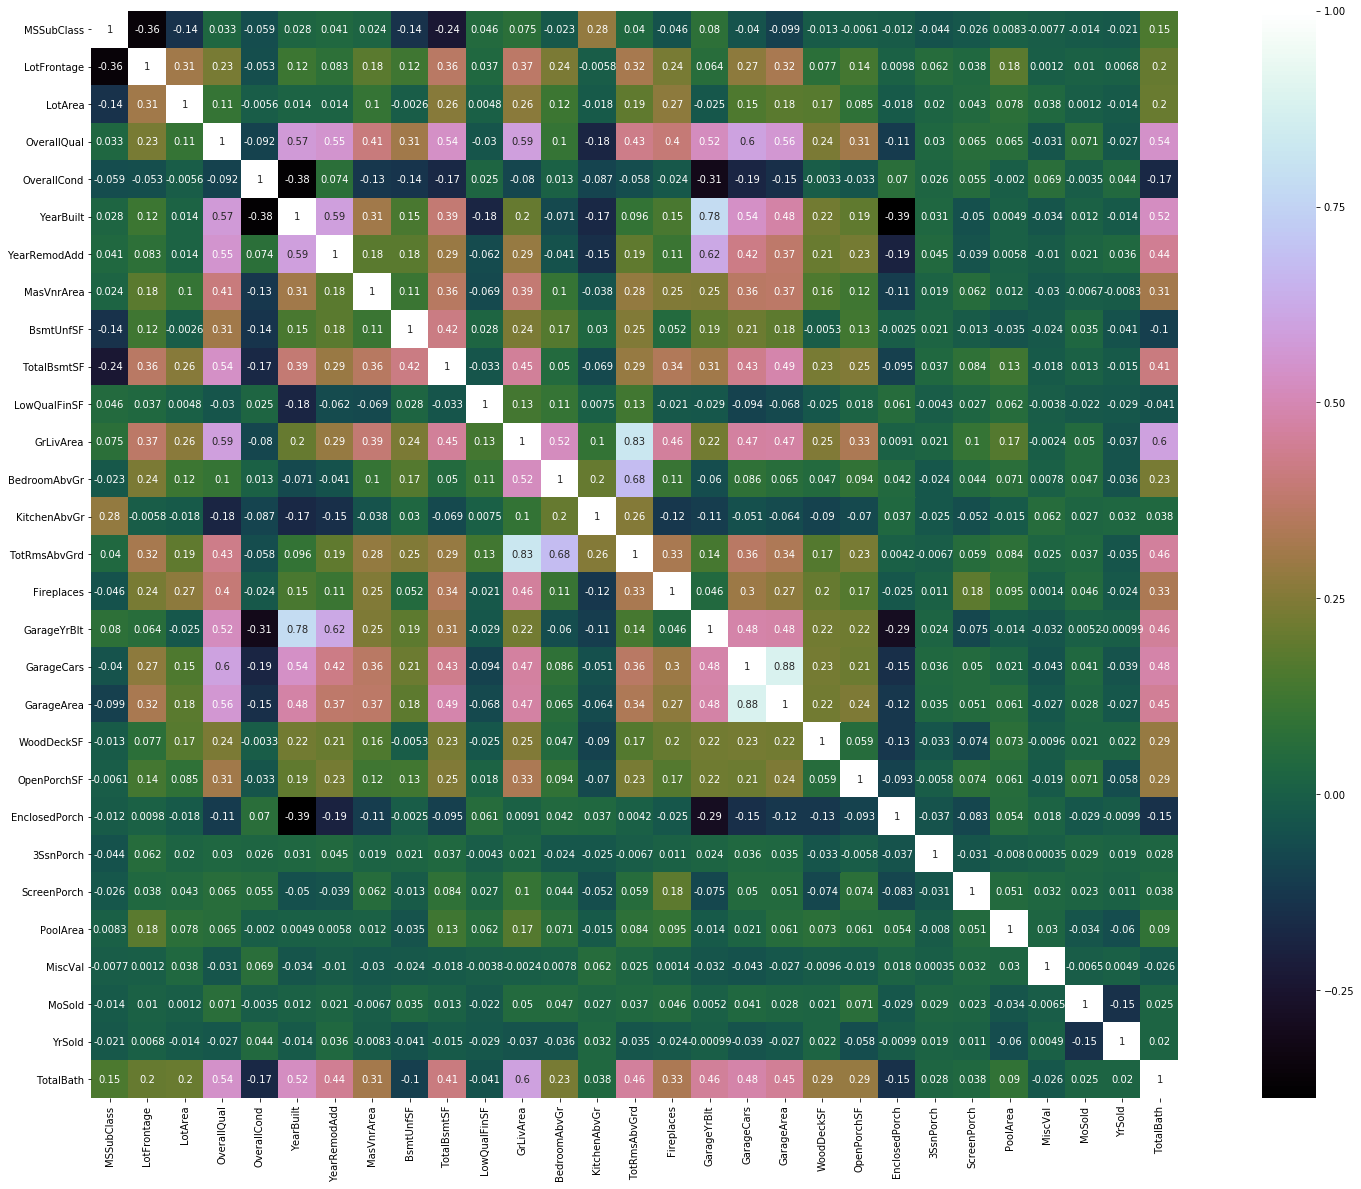

In [4]:
train_data_no_sale_price = train_data.drop(["SalePrice"], axis=1)
corr_mat = train_data_no_sale_price.corr(method='pearson')
plt.figure(figsize=(30,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

In [5]:
corr_pairs = corr_mat.abs().unstack().sort_values()
corr_pairs[corr_pairs != 1][corr_pairs >.75]

GarageYrBlt   YearBuilt       0.780555
YearBuilt     GarageYrBlt     0.780555
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
dtype: float64

In [6]:
def compair_graph(data, x, y, x_dis, y_dis):
    df = data[[x, y]]

    poly_data = pd.DataFrame({'xfit': np.linspace(df[x].min(), df[x].max(), 500)})
    poly_data[str(1)] = np.poly1d(np.polyfit(df[x], df[y], 1))(poly_data['xfit'])

    chart = alt.Chart(df[[x, y]]).mark_circle(size=120).encode(
        alt.X(x, scale=alt.Scale(zero=False)),
        alt.Y(y, scale=alt.Scale(zero=False))
    ).properties(
        title=f'{x_dis} vs {y_dis}'
    )

    polynomial_fit = alt.Chart(poly_data).mark_line().encode(
        x=alt.X('xfit', axis=alt.Axis(title=x_dis)),
        y=alt.Y('1', axis=alt.Axis(title=y_dis)),
        color=alt.value("#FFAA00")
    )

    return chart + polynomial_fit

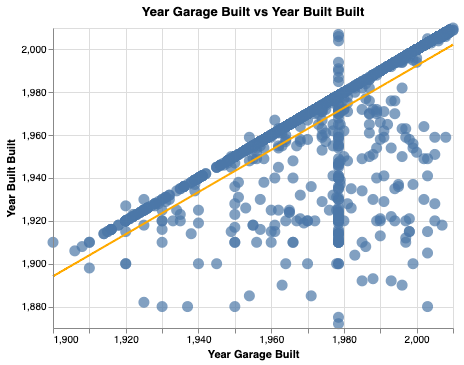

In [7]:
compair_graph(train_data, 'GarageYrBlt', 'YearBuilt', 'Year Garage Built', 'Year Built Built')

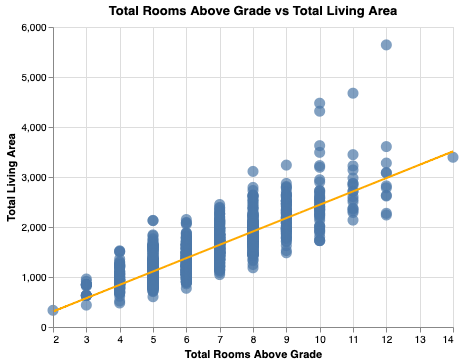

In [8]:
compair_graph(train_data, 'TotRmsAbvGrd', 'GrLivArea', 'Total Rooms Above Grade', 'Total Living Area')

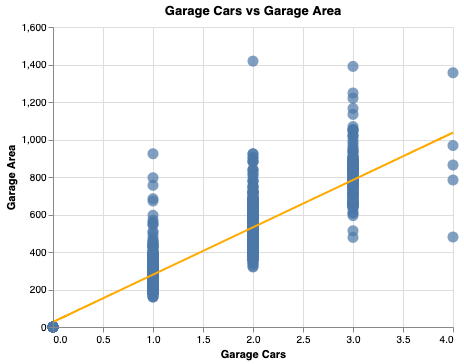

In [9]:
compair_graph(train_data, 'GarageCars', 'GarageArea', 'Garage Cars', 'Garage Area')

#### There are 3 pairs with high corrilation. Drop 1 of each pair

In [10]:
train_data.drop(["TotRmsAbvGrd", "GarageYrBlt", "GarageCars"], axis=1, inplace=True)
test_data.drop(["TotRmsAbvGrd", "GarageYrBlt", "GarageCars"], axis=1, inplace=True)

## Remove features that are not correlated with sale price.

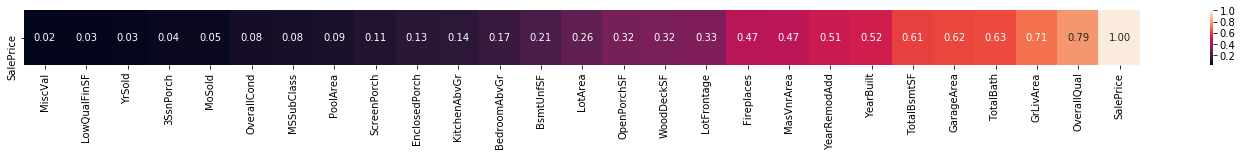

In [11]:
num = train_data.select_dtypes(exclude = 'object')
numcorr = num.corr()
f, ax = plt.subplots(figsize = (25,1))
numcorr.sort_values(by = 'SalePrice', ascending = False).head(1)
corr_with_price = numcorr.sort_values(by = 'SalePrice', ascending = False).head(1)
corr_with_price = abs(corr_with_price).sort_values(by ='SalePrice', axis=1)
sns.heatmap(corr_with_price, annot = True, fmt=".2f")
plt.show()

<Figure size 4320x1080 with 0 Axes>

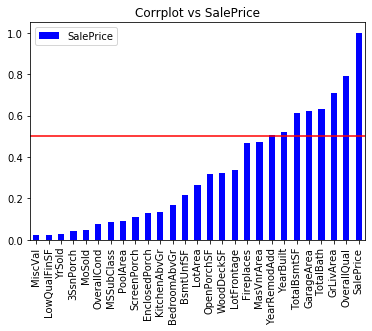

In [12]:
plt.subplots(1,0,figsize=(60,15))
numcorr['SalePrice'].abs().sort_values(ascending=True).to_frame().plot.bar(color = 'blue')
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title('Corrplot vs SalePrice')
plt.show()

In [13]:
corr_with_price = corr_with_price.abs().unstack().sort_values()
corr_with_price[corr_with_price < .05]

MiscVal       SalePrice    0.021190
LowQualFinSF  SalePrice    0.025606
YrSold        SalePrice    0.028923
3SsnPorch     SalePrice    0.044584
MoSold        SalePrice    0.046432
dtype: float64

##### We deleted 6 attributes because they has low corrilation (< 5%)

In [14]:
train_data.drop(["MiscVal", "LowQualFinSF", "YrSold", "3SsnPorch", "MoSold"], axis=1, inplace=True)
test_data.drop(["MiscVal", "LowQualFinSF", "YrSold", "3SsnPorch", "MoSold"], axis=1, inplace=True)

## Prepare data for predictive models

In [15]:
X_trained = train_data.copy()
Y_trained = train_data['SalePrice']
X_trained.drop(['SalePrice'], axis=1, inplace=True)

In [22]:
print(train_data["LandContour"].unique())
print(test_data["LandContour"].unique())

['Lvl' 'Bnk' 'Low' 'HLS']
['Lvl' 'HLS' 'Bnk' 'Low']


In [16]:
obj_features = X_trained.dtypes[X_trained.dtypes == object].index.to_numpy()

for feature in obj_features:
    print("starting:")
    print(feature)
    print("getting Dummies")
    dummyZoning = pd.get_dummies(X_trained[feature])
    dummyZoning = dummyZoning.add_prefix(feature + " ")
    X_trained = X_trained.join(dummyZoning)
    X_trained.drop([feature], axis=1, inplace=True)

starting:
MSZoning
getting Dummies
starting:
Street
getting Dummies
starting:
LotShape
getting Dummies
starting:
LandContour
getting Dummies
starting:
Utilities
getting Dummies
starting:
LotConfig
getting Dummies
starting:
LandSlope
getting Dummies
starting:
Neighborhood
getting Dummies
starting:
Condition1
getting Dummies
starting:
Condition2
getting Dummies
starting:
BldgType
getting Dummies
starting:
HouseStyle
getting Dummies
starting:
RoofStyle
getting Dummies
starting:
RoofMatl
getting Dummies
starting:
Exterior1st
getting Dummies
starting:
Exterior2nd
getting Dummies
starting:
MasVnrType
getting Dummies
starting:
ExterQual
getting Dummies
starting:
ExterCond
getting Dummies
starting:
Foundation
getting Dummies
starting:
BsmtQual
getting Dummies
starting:
BsmtCond
getting Dummies
starting:
BsmtExposure
getting Dummies
starting:
BsmtFinType1
getting Dummies
starting:
BsmtFinType2
getting Dummies
starting:
Heating
getting Dummies
starting:
HeatingQC
getting Dummies
starting:
Centra

In [24]:
X_trained.shape

(1460, 270)

In [17]:
X_trained_np = StandardScaler().fit_transform(X_trained)

## Split data into a train and validation datasets

In [18]:
number_of_samples = len(X_trained_np)

np.random.seed(0)
random_indices = np.random.permutation(number_of_samples)
num_training_samples = int(number_of_samples*0.75)
x_trains = X_trained_np[random_indices[:num_training_samples]]
y_trains = Y_trained[random_indices[:num_training_samples]]
x_tests = X_trained_np[random_indices[num_training_samples:]]
y_tests = Y_trained[random_indices[num_training_samples:]]
y_trains = list(y_trains)
y_tests = list(y_tests)

# Regressions

#### Set up helper functions

In [19]:
def print_error_message(y_actual, y_predicted, data_prefix, model_name):
    error = 0
    for i in range(len(y_actual)):
        error += (abs(y_predicted[i]-y_actual[i])/y_actual[i])
    error_percent = error/len(y_actual) * 100
    print(f'{data_prefix} error = {round(error_percent, 2)}% in {model_name}')


## Random Forest Regression

In [20]:
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10]
}

rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = params, n_iter = 100, cv = 3, verbose =2, random_state = 42, n_jobs = -1)
rf_random.fit(x_trains, y_trains)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None}

In [21]:
regressor = RandomForestRegressor(n_estimators = 100,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_depth = None)

regressor.fit(x_trains, y_trains)
y1_rfo = list(regressor.predict(x_trains))
y2_rfo = list(regressor.predict(x_tests))

print_error_message(y_trains, y1_rfo, "Train", "Random Forest Regression")
print_error_message(y_tests, y2_rfo, "Validate", "Random Forest Regression")

Train error = 4.46% in Random Forest Regression
Validate error = 9.58% in Random Forest Regression


# Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

params = { 'alpha': [i for i in range(1, 101)] }

ridge_reg = GridSearchCV(Ridge(), param_grid = params,
                        scoring = 'neg_mean_squared_error',
                        cv = 5)

ridge_reg.fit(x_trains, y_trains)
ridge_ytrain = ridge_reg.predict(x_trains)
ridge_yhat = ridge_reg.predict(x_tests)

print(f'r2_square on test set: {r2_score(y_tests, ridge_yhat)}')
print(f'The best value of Alpha is: {ridge_reg.best_params_}')
print_error_message(y_trains, ridge_ytrain, "Train", "Ridge Regression")
print_error_message(y_tests, ridge_yhat, "Validate", "Ridge Regression")

r2_square on test set: 0.9036800238006704
The best value of Alpha is: {'alpha': 100}
Train error = 8.16% in Ridge Regression
Validate error = 8.5% in Ridge Regression


# Lasso Regression

In [23]:
@ignore_warnings(category=ConvergenceWarning)
def lasso_no_warnings(x, y):
    parameters = {'alpha': [0.0001, 0.0009, 0.001, 0.002, 0.002, 0.01, 0.1, 1, 10, 100]}
    lasso_reg = GridSearchCV(Lasso(), param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
    return lasso_reg.fit(x, y)

lasso_reg = lasso_no_warnings(x_trains, y_trains)
lasso_ytrain = lasso_reg.predict(x_trains)
lasso_yhat = lasso_reg.predict(x_tests)


print(f'rmse on train set: {np.sqrt(mse(y_trains, lasso_ytrain))}')
print(f'rmse on test set: {np.sqrt(mse(y_tests, lasso_yhat))}')
print(f'r2_square on test set: {r2_score(y_tests, lasso_yhat)}')
print(f'The best value of Alpha is: {lasso_reg.best_params_}')
print_error_message(y_trains, lasso_ytrain, "Train", "Ridge Regression")
print_error_message(y_tests, lasso_yhat, "Validate", "Ridge Regression")

rmse on train set: 21627.662128074877
rmse on test set: 21797.143330767027
r2_square on test set: 0.9037121325073533
The best value of Alpha is: {'alpha': 100}
Train error = 8.06% in Ridge Regression
Validate error = 8.74% in Ridge Regression
